# Terminal commands for data access

```
ssh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -o follow_symlinks  -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs -o follow_symlinks vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=10g tmpfs /mnt/ramdisk/ && mkdir /mnt/ramdisk/data

# then copy the file to the ramdisk
rsync -av /mnt/murphy_workspace/NSTT/outputs/LabelTransfer/TNBC/*csv /mnt/ramdisk/data/
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

In [4]:
%matplotlib inline
import anndata
import novosparc
import os
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import random
import squidpy as sq
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

'# Data

symlinked to `/data/local/rajewsky/home/vschuma/NSTT/outputs/LabelTransfer/TNBC`
## TNBC in-house atlas

In [5]:
%%time
# atlas coordinates
#atlas_dir = 'output'
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, 'TNBC_6w_fc51_4_coordinates.csv')
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# atlas data
atlas_path = os.path.join(atlas_dir, 'TNBC_reconstruction_atlas.csv')
chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)
print(locations.shape)
atlas.obsm['spatial'] = locations

600
(55478, 600)
(55478, 2)
CPU times: user 4.77 s, sys: 278 ms, total: 5.05 s
Wall time: 5.05 s


<timed exec>:14: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
locations.shape

(55478, 2)

In [ ]:
n_loc = 100
sc.pp.subsample(atlas, n_obs=n_loc)

In [35]:
locations = atlas.obsm['spatial']
locations_apriori = locations

In [29]:

atlas_genes = atlas.var.index.tolist()
print(len(atlas_genes))
print(atlas.shape)

600
(100, 600)


## TNBC single-nuclei data

for preprocessing and information see `metadata_transfer_TNBC_sndata.ipynb`

In [8]:
%%time
# Reading expression data to scanpy AnnData (cells x genes)
# data_dir = 'output'
data_dir = 'data'
data_path = os.path.join(data_dir, 'TNBC_sn_integrated_dge.csv')
dataset = sc.read(data_path).T
# normalize dataset
# sc.pp.normalize_per_cell(dataset)

CPU times: user 27.6 s, sys: 325 ms, total: 27.9 s
Wall time: 21h 34min 43s


In [9]:
dataset.X

array([[ 5.8934674e+00, -5.7805735e-01,  5.7280064e-01, ...,
        -1.3563628e-01, -4.2446665e-02, -2.2691300e-02],
       [-1.0600517e+00, -2.9747206e-01, -3.5787937e-01, ...,
        -3.5414642e-03, -2.0549065e-02, -7.4666883e-03],
       [-1.6088870e+00, -1.9510115e+00, -6.4729494e-01, ...,
        -4.6129510e-02, -5.2268848e-02, -3.0158432e-02],
       ...,
       [-2.6786259e-01, -1.3156468e+00, -4.3719316e-01, ...,
        -1.8828461e-02,  1.4452153e-01, -6.6800108e-03],
       [-1.5471711e+00, -2.2378309e+00,  9.6039307e-01, ...,
        -1.2208468e-02,  1.6552719e-01, -1.3920693e-02],
       [ 6.0600823e-01,  1.0065595e+00,  8.6365265e-01, ...,
         4.4659800e-03, -1.4674928e-02, -3.4882145e-03]], dtype=float32)

In [10]:

gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells total: %d' % num_cells)
print('number of genes: %d' % num_genes)

# use only a subset for testing
num_cells = 100
print('number of cells used: %d' % num_cells)
sc.pp.subsample(dataset, n_obs=num_cells)

number of cells total: 26978
number of genes: 3000
number of cells used: 100


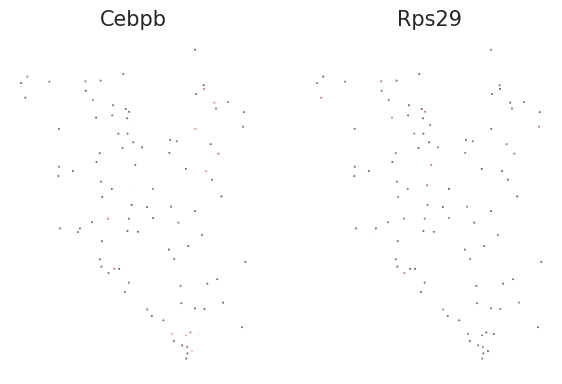

<Figure size 432x288 with 0 Axes>

In [11]:
# only some genes
pl_genes = ['Cebpb', 'Rps29',]
# raw atlas
novosparc.pl.embedding(atlas, pl_genes,
                       pt_size=0.1, size_x=7, size_y=4.5)
                        # todo: this should throw an error when the pl_genes input format is wrong,
                        # why are the dots not filled anymore?
                        # there should be an info about the size unit
                        # why does the size of the whole thing does not automatically get's adjusted when I change the x,y size?

# all the genes
# pl_genes = atlas.var.index.to_frame()
# novosparc.pl.embedding(atlas, pl_genes.values.flatten().tolist())


# Reconstruction
## create tissue object

In [36]:
%%time
# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

CPU times: user 1.3 ms, sys: 1.01 ms, total: 2.31 ms
Wall time: 2.04 ms


In [37]:
%%time
# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
# small subset for testing purposes
markers = random.sample(markers,5)
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

CPU times: user 2.03 ms, sys: 0 ns, total: 2.03 ms
Wall time: 1.93 ms


### Reconstruct using atlas only, reduced marker set

In [38]:
%%time
# using only linear cost to test if this is faster
# subsample markers to use
tissue.setup_linear_cost(markers_to_use, atlas_matrix)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 5 markers: 100 cells and 100 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03
CPU times: user 396 ms, sys: 921 ms, total: 1.32 s
Wall time: 141 ms


In [39]:
print(type(tissue))
tissue.sdge

<class 'novosparc.common._tissue.Tissue'>


array([[-7.78577824e-04, -1.06871289e-03,  7.18955192e-05, ...,
         1.66766820e-05, -6.25207224e-04, -1.07057242e-03],
       [-7.65159993e-03, -6.84340922e-03, -8.79517912e-03, ...,
        -8.73595988e-03, -7.91416875e-03, -5.76088482e-03],
       [ 5.56325358e-04, -5.66596685e-04,  2.84356474e-03, ...,
         2.70930532e-03,  1.01875793e-03, -1.37516663e-03],
       ...,
       [-2.46657423e-04, -2.44707776e-04, -2.32179455e-04, ...,
        -2.33501033e-04, -2.45349622e-04, -2.37889035e-04],
       [-4.52696892e-04, -4.63007430e-04, -4.17859878e-04, ...,
        -4.20386950e-04, -4.47234881e-04, -4.87785516e-04],
       [ 6.15370935e-04,  2.61597974e-04,  1.32251209e-03, ...,
         1.28045624e-03,  7.57632089e-04, -1.64266258e-05]])

### Reconstruct using both assumptions, reduced marker set

In [ ]:
# %%time
# # alternative 1: setup both assumptions
# # setup smooth
# num_neighbors_s = num_neighbors_t = 5
#
# tissue_alt = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)
# tissue_alt.setup_reconstruction(atlas_matrix=atlas_matrix,
#                             markers_to_use=markers_to_use,
#                             num_neighbors_s=num_neighbors_s,
#                             num_neighbors_t=num_neighbors_t)
#
# # compute optimal transport of cells to locations
# alpha_linear = 0.1
# epsilon = 5e-3
# # tissue.dge = sparse.csr_matrix(tissue.dge)
# tissue_alt.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

## save tissue object

**ToDo**
Try pickle object: https://pythonexamples.org/python-pickle-class-object/

In [18]:
import pickle
save_dir = 'saved_objcs/'

In [19]:
%%time

#create a pickle file
tissue_file = os.path.join(save_dir,"tissue_5Marker_1kCells_3kLocations.pkl")
picklefile = open(tissue_file, 'wb')
#pickle the dictionary and write it to file
pickle.dump(tissue, picklefile)
#close the file
picklefile.close()

CPU times: user 3.16 s, sys: 26.2 s, total: 29.4 s
Wall time: 44.2 s


### unpickle the file

In [20]:
#read the pickle file
picklefile = open(tissue_file, 'rb')
#unpickle the dataframe
tissue_pkled = pickle.load(picklefile)
#close file
picklefile.close()

#print the dataframe
print(type(tissue_pkled))

<class 'novosparc.common._tissue.Tissue'>


AttributeError: 'Tissue' object has no attribute 'details'

# Plotting
## Create tissue anndata

In [24]:
type(tissue_pkled.sdge)

NoneType

In [40]:
# create
dataset_tissue = sc.AnnData(pd.DataFrame(tissue.sdge.T, columns = gene_names), dtype=float)
dataset_tissue.obsm['spatial'] = locations

# save\
dataset_tissue.write(os.path.join(save_dir, 'TNBC_tissue_sdge_basicRecon.h5ad'))

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Finding marker genes

### read in big marker gene list

In [17]:
gene_table = os.path.join("data", '6week_all_markers.csv')
all_marker_genes = pd.read_csv(gene_table, sep=',')
marker_genes = all_marker_genes['gene'].tolist()
all_marker_genes

p_val  avg_log2FC  pct.1  pct.2      p_val_adj  cluster  \
0      1.001351e-126    0.183331  0.289  0.158  3.473486e-122  low_UMI   
1      1.346538e-113    0.167937  0.346  0.205  4.670869e-109  low_UMI   
2       4.712664e-35    0.089403  0.240  0.171   1.634729e-30  low_UMI   
3       8.571468e-29    0.074106  0.175  0.121   2.973271e-24  low_UMI   
4       2.257903e-28    0.062678  0.162  0.110   7.832213e-24  low_UMI   
...              ...         ...    ...    ...            ...      ...   
24035  3.783217e-176    0.031251  0.523  0.244  1.312322e-171  low_UMI   
24036  3.374173e-112    0.052781  0.504  0.277  1.170433e-107  low_UMI   
24037   1.022758e-80    0.068989  0.108  0.033   3.547744e-76  low_UMI   
24038   4.730852e-35    0.038639  0.122  0.059   1.641038e-30  low_UMI   
24039   1.329192e-26    0.024588  0.144  0.081   4.610703e-22  low_UMI   

         gene  cell_type  compartment  
0      Clec3b        NaN          NaN  
1      Igfbp6        NaN          NaN  
2         Dpt        NaN          NaN  
3        Penk        NaN          NaN  
4        Pi16        NaN          NaN  
...       ...        ...          ...  
24035  Csn1s1        NaN          NaN  
24036    Csn3        NaN          NaN  
24037     Wap        NaN          NaN  
24038   Lalba        NaN          NaN  
24039    Saa2        NaN          NaN  

[24040 rows x 9 columns]

### find genes that are in all lists (atlas, data, marker)

In [18]:
overlap_genes = list(set(atlas_genes) & set(marker_genes) & set(gene_names))
print(overlap_genes)

['Neb', 'Rps29', 'Cebpb']


In [19]:
for gene in overlap_genes:
 print(f"{gene} is a marker for: ","\n")
 print(all_marker_genes[all_marker_genes['gene'] == 'Cebpb']['cluster'])

Neb is a marker for:  

747      Tumor_luminal_1
4339       Tumor_Basal_1
6345          CAF_lowTnc
7287       Tumor_Basal_2
10328       Wap_positive
13117      Keratin_perls
16532       Normal_ducts
18835    Hormone_sensing
21446       CAFs_highTnc
22745    Tumor_luminal_2
Name: cluster, dtype: object
Rps29 is a marker for:  

747      Tumor_luminal_1
4339       Tumor_Basal_1
6345          CAF_lowTnc
7287       Tumor_Basal_2
10328       Wap_positive
13117      Keratin_perls
16532       Normal_ducts
18835    Hormone_sensing
21446       CAFs_highTnc
22745    Tumor_luminal_2
Name: cluster, dtype: object
Cebpb is a marker for:  

747      Tumor_luminal_1
4339       Tumor_Basal_1
6345          CAF_lowTnc
7287       Tumor_Basal_2
10328       Wap_positive
13117      Keratin_perls
16532       Normal_ducts
18835    Hormone_sensing
21446       CAFs_highTnc
22745    Tumor_luminal_2
Name: cluster, dtype: object


### plot

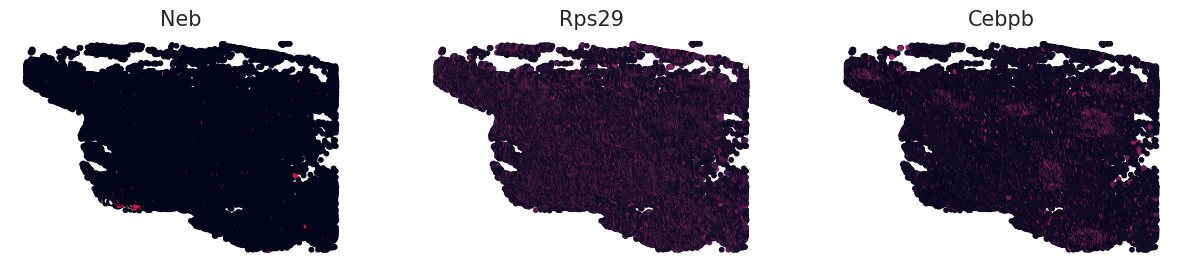

<Figure size 432x288 with 0 Axes>

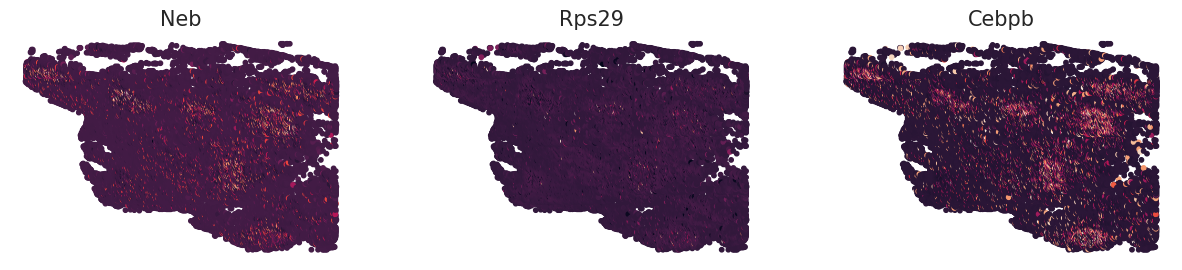

<Figure size 432x288 with 0 Axes>

In [20]:
novosparc.pl.embedding(atlas, overlap_genes)
novosparc.pl.embedding(dataset_tissue, overlap_genes)

# Metadata
## meta data

In [22]:
meta_data_dir = 'output'
# ToDo: Here could be a loop that fetches all available metadata files and merges them, or write it as a function which takes a dir of meta-data files or multiple files as input
meta_ct_path = os.path.join(meta_data_dir, "TNBC_meta_phase.csv")

phase_raw = pd.read_csv(meta_ct_path)
phase = np.asarray(phase_raw)

## gw from tissue

In [23]:
## prepare gw matrix
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
print(gw_matrix.shape[0])

100


## merge metadata + gw

In [24]:
print(phase_raw.shape)
print(gw_matrix.shape)

(26978, 1)
(100, 55478)


In [31]:
p_gw_merge = gw_matrix.join(phase_raw)
print(p_gw_merge.shape)
print(p_gw_merge[:3])

(100, 55479)
              0             1             2             3             4  \
0  1.110212e-07  1.836213e-07  3.441560e-07  2.057122e-07  1.259201e-07   
1  2.739285e-07  2.141261e-07  1.414827e-07  2.015747e-07  2.580267e-07   
2  4.564495e-11  1.401394e-11  3.084354e-12  1.079671e-11  3.374939e-11   

              5             6             7             8             9  ...  \
0  1.415006e-07  2.663113e-07  3.483003e-07  1.946698e-07  1.918055e-07  ...   
1  2.439350e-07  1.728733e-07  1.398706e-07  2.076532e-07  2.092910e-07  ...   
2  2.562766e-11  5.916657e-12  2.983522e-12  1.225463e-11  1.267871e-11  ...   

          55469         55470         55471         55472         55473  \
0  1.746200e-07  1.222137e-07  1.114383e-07  1.147673e-07  1.250972e-07   
1  2.197396e-07  2.617302e-07  2.734434e-07  2.696617e-07  2.588359e-07   
2  1.573110e-11  3.623848e-11  4.523279e-11  4.213188e-11  3.427972e-11   

          55474         55475         55476         55477  Phase

In [9]:
print(type(tissue))
tissue

<class 'novosparc.common._tissue.Tissue'>


Setting up for reconstruction ... 

In [49]:
# create
dataset_tissue = sc.AnnData(pd.DataFrame(tissue.sdge.T, columns = gene_names), dtype=float)
dataset_tissue.obsm['spatial'] = locations

# save\
# dataset_tissue.write(os.path.join(save_dir, 'TNBC_tissue_sdge_basicRecon.h5ad'))

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [34]:
atlas.obsm['spatial']

array([[ 28429.98111637,  35944.28043282],
       [ 28429.98111637,  36503.38793282],
       [ 28751.21498815,  35944.28043282],
       ...,
       [ 97357.40805752, 114930.32996648],
       [ 97357.40805752, 115489.27996648],
       [ 97357.40805752, 116048.22996648]])

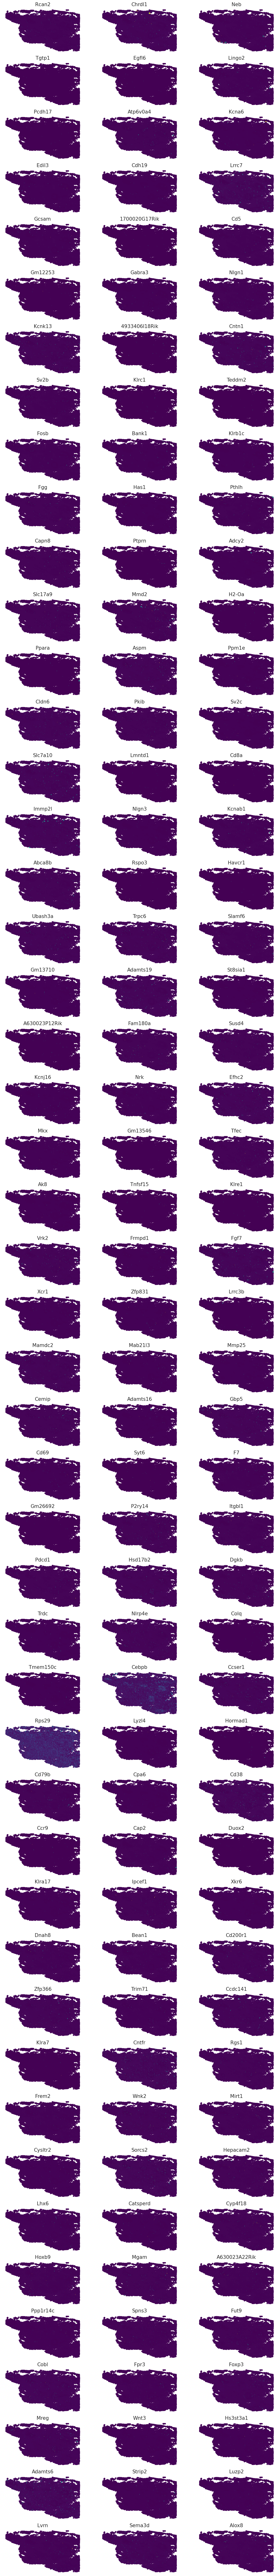

<Figure size 432x288 with 0 Axes>

In [58]:
overlap_genes = list(set(atlas_genes) & set(gene_names))

novosparc.pl.embedding(atlas, overlap_genes)